In [1]:
import os
import numpy as np
import scienceplots
import matplotlib.pyplot as plt

# Entropy Profiling

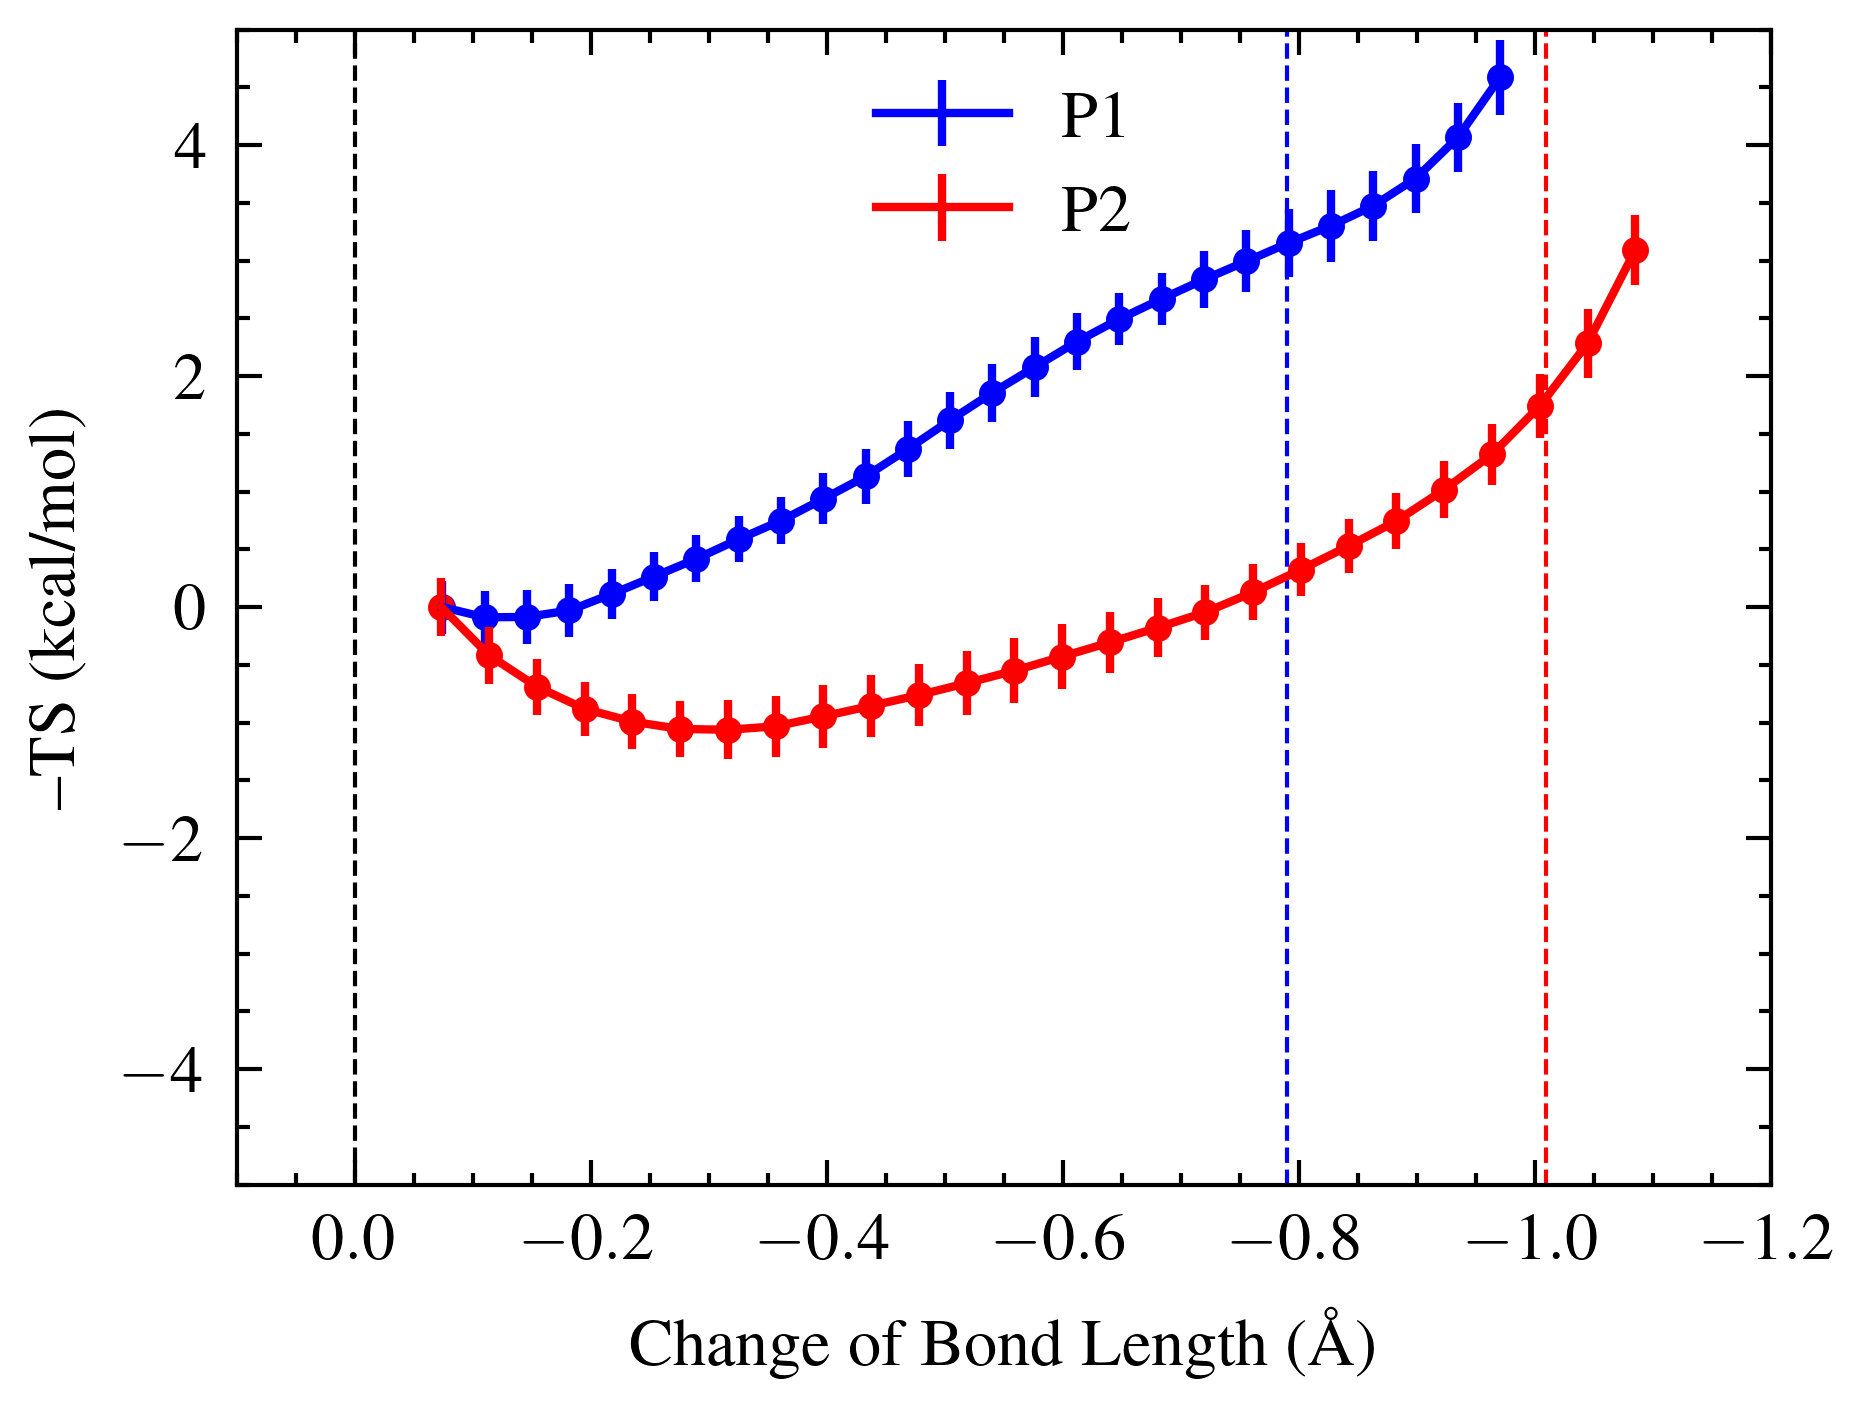

In [2]:
def load_data(filepath):
    return np.load(filepath)

def calculate_statistics(data):
    mean = np.mean(data, axis=0)
    stdev = np.std(data, axis=0)
    return mean, stdev

def prepare_x_values(bond_max, bond_min, bond_ens, bond_other_max):
    x = np.linspace(bond_max, bond_min, bond_ens)
    dx = (x[0] - x[1]) / 2
    x_run_avg = np.linspace(x[0], x[-2], 30) - bond_other_max - dx
    return x_run_avg, dx

def plot_data(ax, x, mean, stdev, color, label):
    ax.errorbar(x, np.subtract(mean, mean[0]), yerr=stdev, color=color, ls='-', label=label)
    ax.scatter(x, np.subtract(mean, mean[0]), s=5, color=color)

reaction = 'dta'
bond2_params = (2.790, 1.602, 9) # bondmax, bondmin, number of structural ensembles
bond3_params = (3.009, 1.689, 10) # bondmax, bondmin, number of structural ensembles

r1 = load_data(f'./log/{reaction}_r2p_1/{reaction}_r2p_1_eps.npy')
r2 = load_data(f'./log/{reaction}_r2p_2/{reaction}_r2p_2_eps.npy')

r1mean, r1stdev = calculate_statistics(r1)
r2mean, r2stdev = calculate_statistics(r2)

x1_run_avg, dx1 = prepare_x_values(*bond2_params, bond2_params[0])
x2_run_avg, dx2 = prepare_x_values(*bond3_params, bond3_params[0])

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    plot_data(ax, x1_run_avg[:-4], r1mean[:-4], r1stdev[:-4], 'blue', 'P1')
    plot_data(ax, x2_run_avg[:-4], r2mean[:-4], r2stdev[:-4], 'red', 'P2')
    ax.set_ylabel('--TS (kcal/mol)')
    ax.set_xlabel('Change of Bond Length (Å)')
    ax.set_ylim(-5, 5)
    ax.set_xlim(0.1, -1.2)
    ax.legend(loc='upper center')
    ax.vlines(x=0, ymin=-5, ymax=5, colors='black', ls='--', lw=0.5)
    ax.vlines(x=2.0 - bond2_params[0], ymin=-5, ymax=5, colors='blue', ls='--', lw=0.5)
    ax.vlines(x=2.0 - bond3_params[0], ymin=-5, ymax=5, colors='red', ls='--', lw=0.5)
    plt.show()


# Entropy Decomposition Analysis

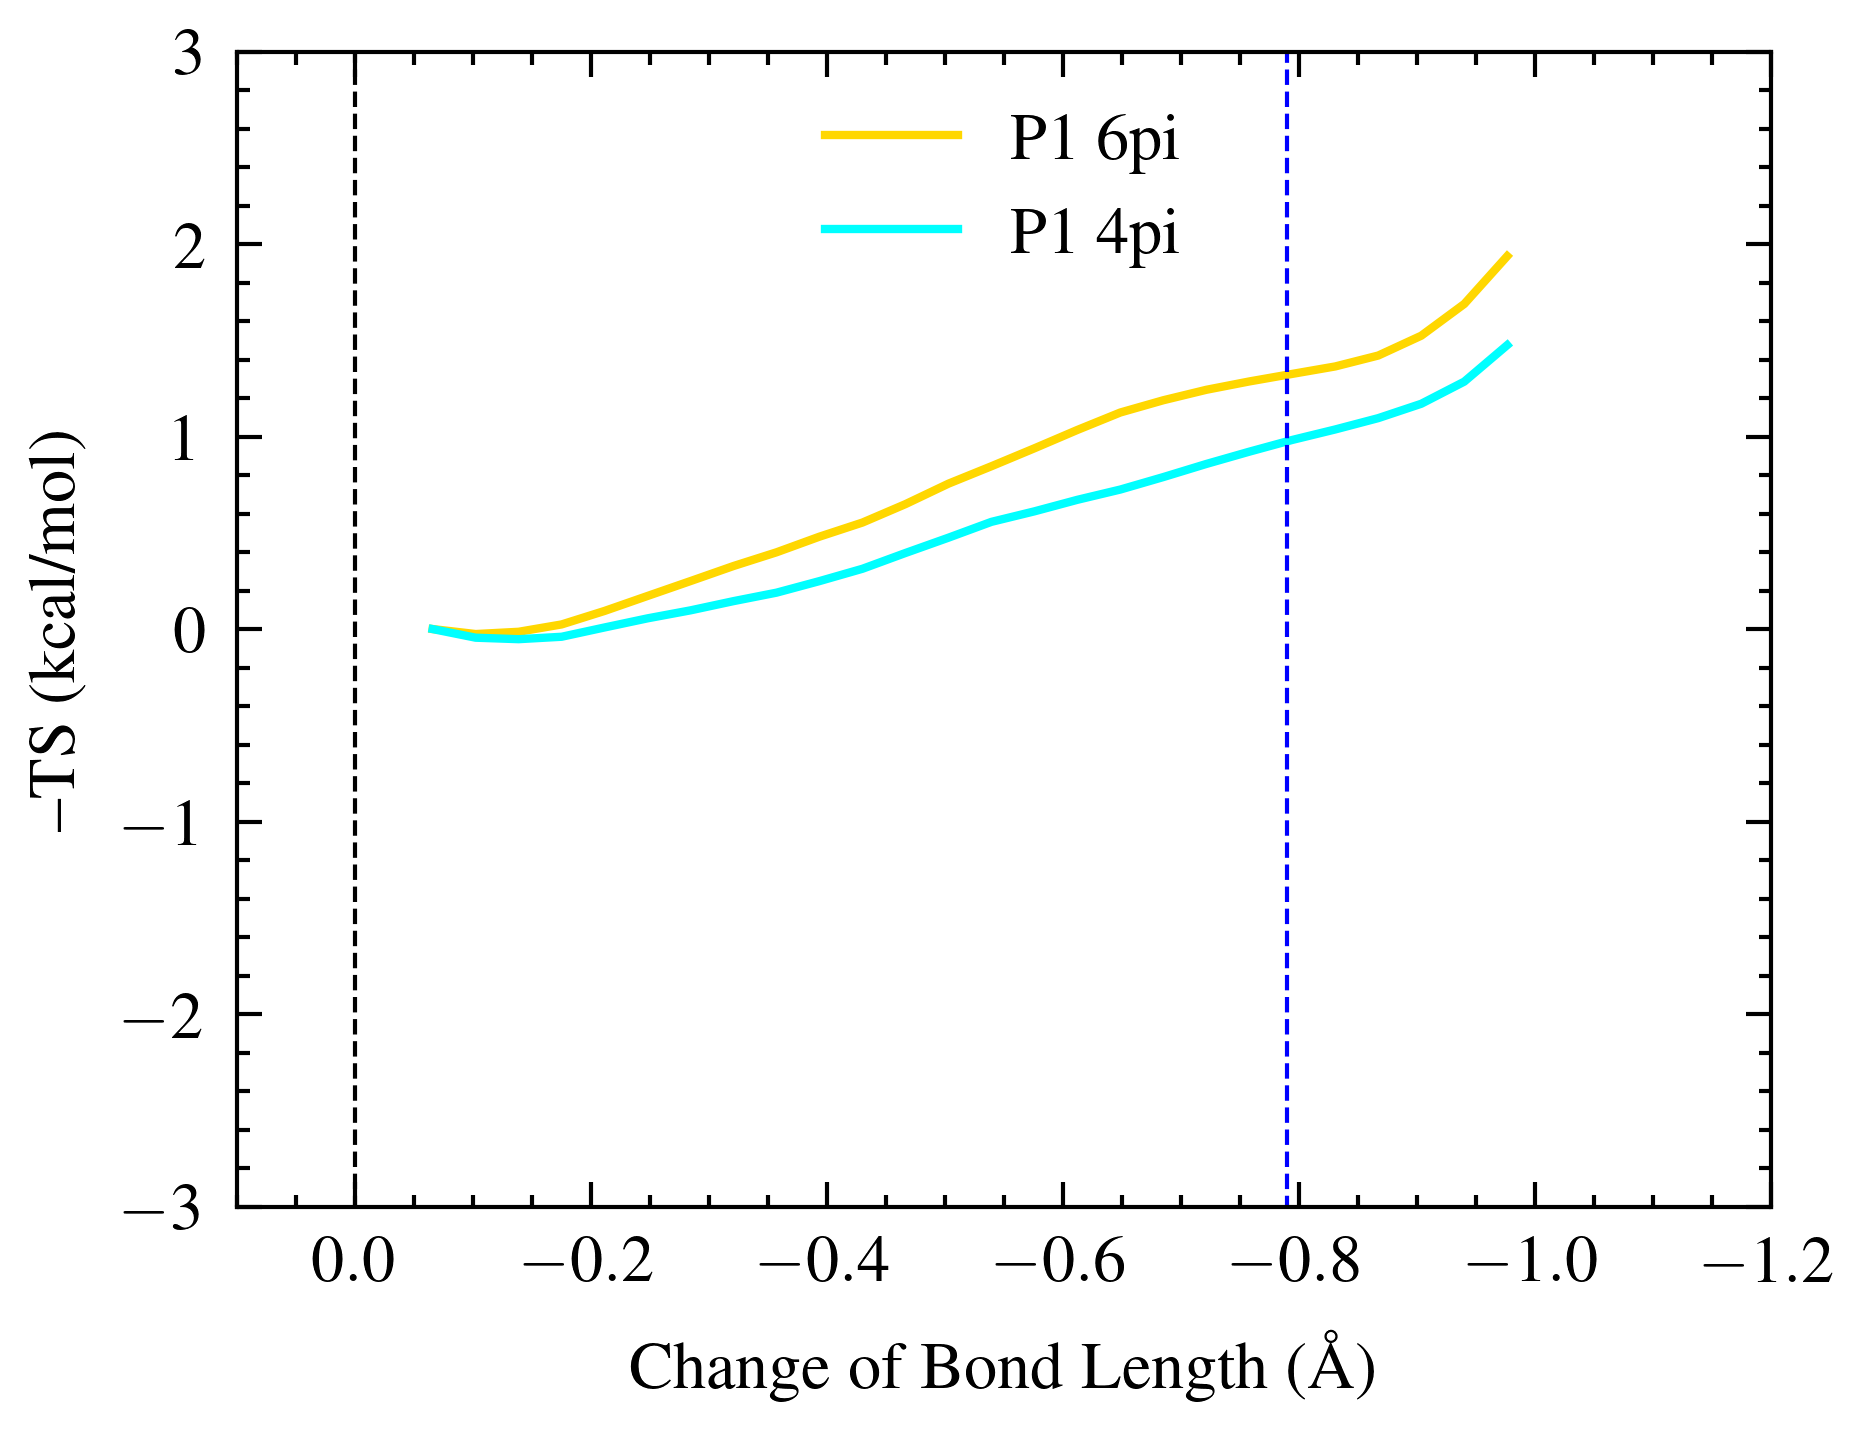

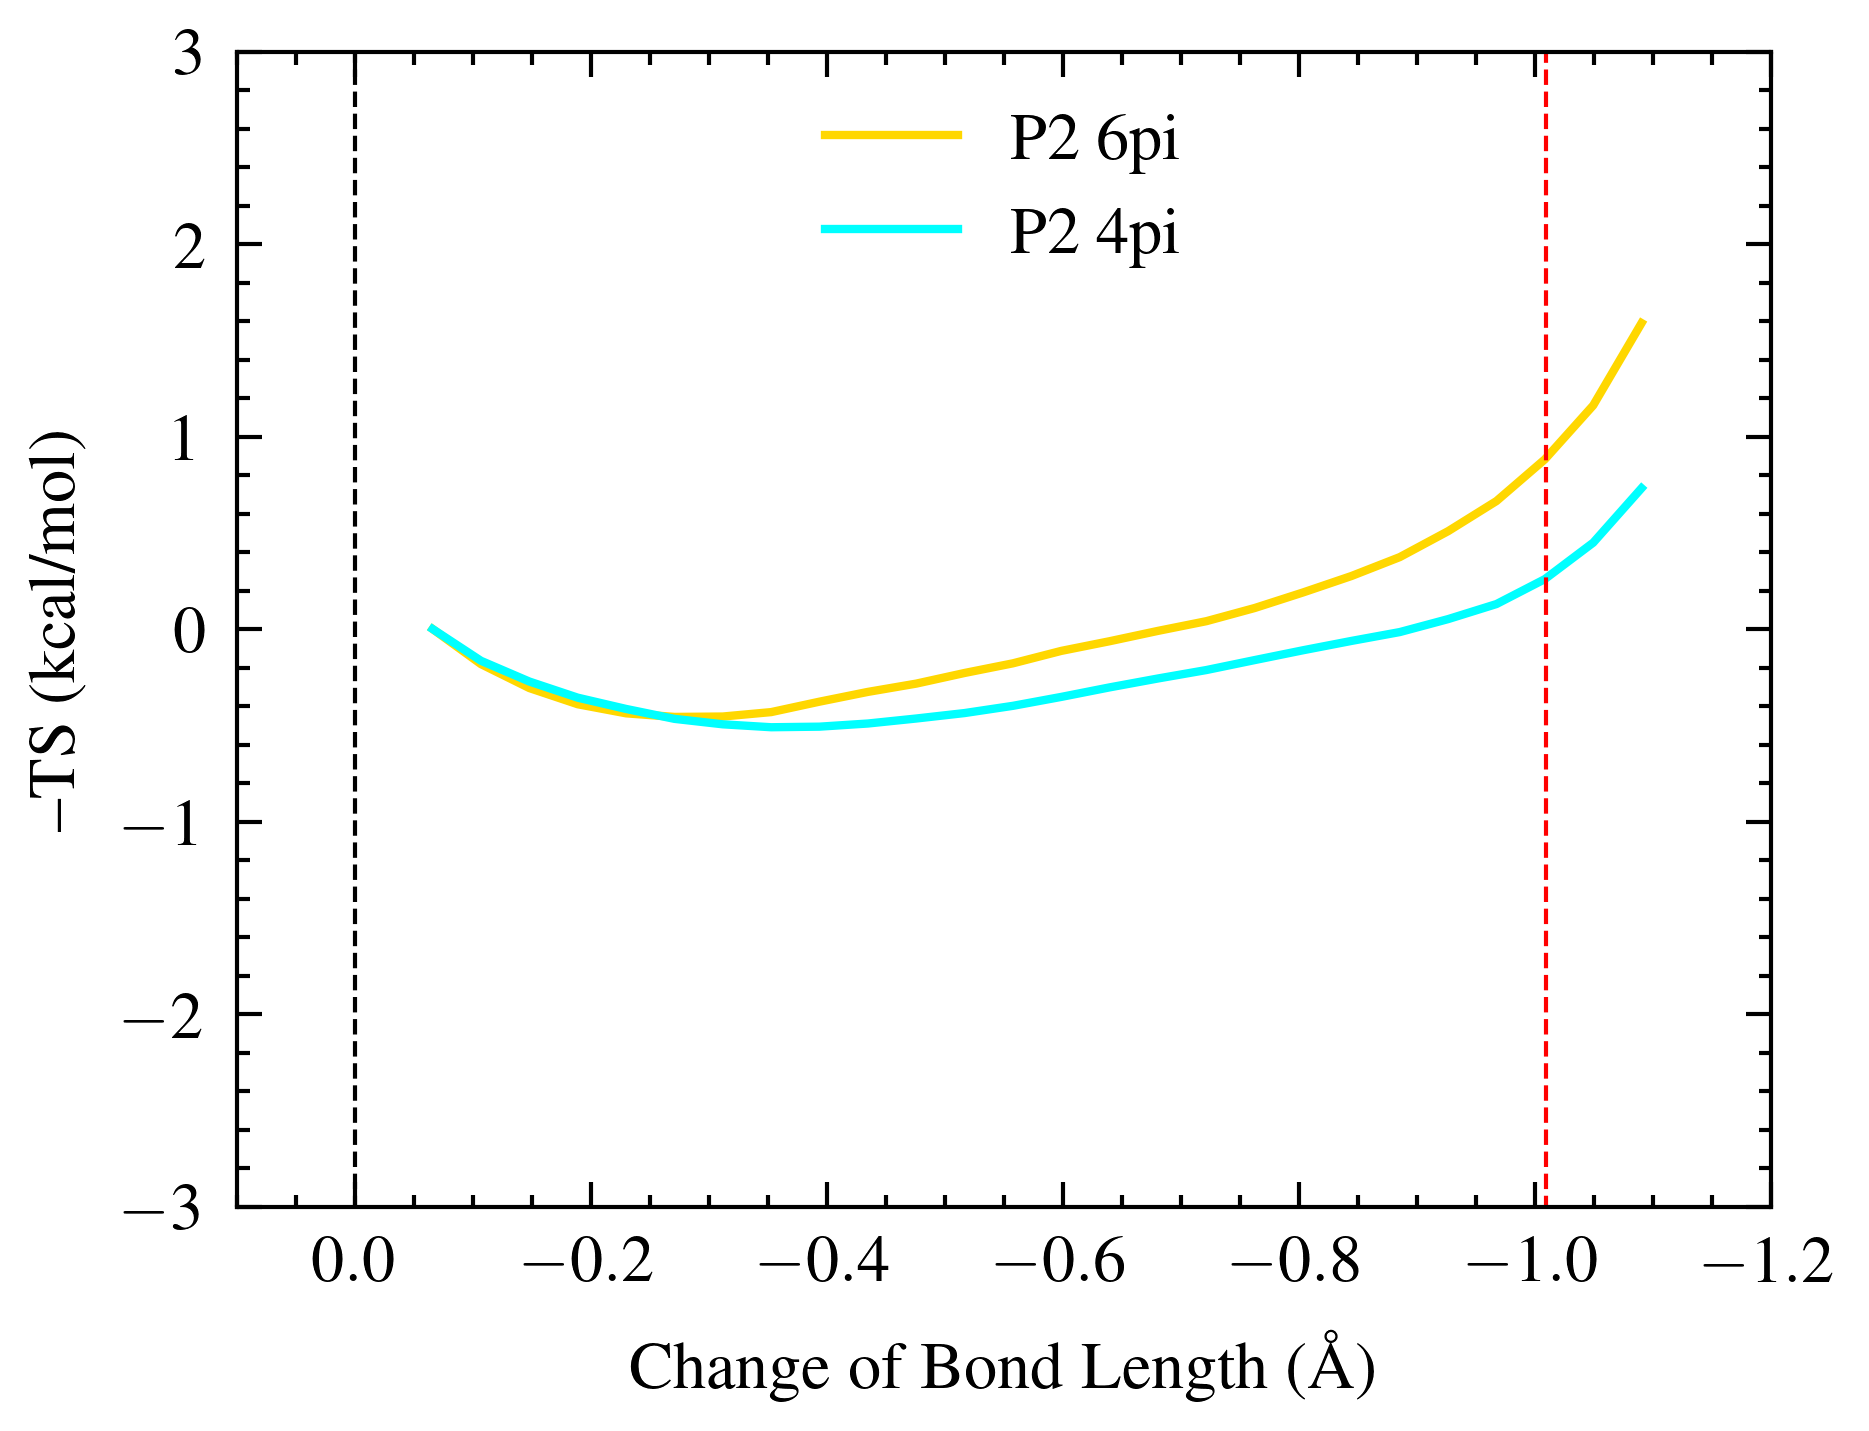

In [3]:
def read_dof_list(filepath):
    with open(filepath, "r") as file:
        dof_list = [list(map(int, line.split())) for line in file.readlines()[1:]]
    return dof_list

def get_moiety_indices(dof_list, moiety_atoms):
    return [index for index, dof in enumerate(dof_list) if all(item in moiety_atoms for item in dof)]

def calculate_factors(dof_list, moiety_indices, moiety_atoms):
    return [
        (len(moiety_atoms) - n) / len([dof_list[i] for i in moiety_indices if len(dof_list[i]) == n])
        for n in range(2, 5)
    ]

def calculate_mi_factors(dof_list, moiety_indices, moiety_atoms):
    return [
        (len(moiety_atoms) - n) / (len([dof_list[i] for i in moiety_indices if len(dof_list[i]) == n]) - 1)
        for n in range(2, 5)
    ]

def read_s1d(filepath, dof_list_length):
    with open(filepath, "r") as file:
        lines = file.readlines()
    return [float(line.split()[-1]) for line in lines[:dof_list_length]], [float(line.split()[-1]) for line in lines[dof_list_length:-5]]

def calculate(moiety_indices, factors, r2p_s1d, mi_2d):
    r2p_value = 0.0
    for i in moiety_indices:
        r2p_value += r2p_s1d[i] * factors[len(dof_list[i]) - 2]
    for i in range(len(moiety_indices) - 1):
        r2p_value -= max([mi_2d[moiety_indices[i]][j] for j in moiety_indices[i + 1:]]) * factors[len(dof_list[i]) - 2]
    return r2p_value

factor = -1.987204259e-3 * 298.15
reaction = 'dta'
moiety4pi_atoms = [1, 2, 6, 11, 24, 19, 7, 12, 14, 15]
moiety6pi_atoms = [10, 3, 4, 5, 8, 13, 22, 23, 20, 21, 9, 16, 17, 18]

parameters = {
    1: (2.790, 1.602, 9),
    2: (3.009, 1.689, 10)
}

with plt.style.context(['science', 'ieee']):
    for num, (bmax, bmin, ensem) in parameters.items():
        dof_list = read_dof_list(f'./log/{reaction}_r2p_{num}/topology.txt')

        moiety6pi_indices = get_moiety_indices(dof_list, moiety6pi_atoms)
        moiety4pi_indices = get_moiety_indices(dof_list, moiety4pi_atoms)

        factor_6pi = calculate_factors(dof_list, moiety6pi_indices, moiety6pi_atoms)
        factor_4pi = calculate_factors(dof_list, moiety4pi_indices, moiety4pi_atoms)
        MI_factor_6pi = calculate_mi_factors(dof_list, moiety6pi_indices, moiety6pi_atoms)
        MI_factor_4pi = calculate_mi_factors(dof_list, moiety4pi_indices, moiety4pi_atoms)

        x = np.linspace(bmax, bmin, ensem + 1)
        dx = x[0] - x[1]
        x = np.linspace(x[0], x[-2], 30)

        S4pi, S6pi = [], []
        for xind in range(30):
            r2p_6pi, r2p_4pi = [], []
            for pt in range(1, 21):
                eps = f'eps_{x[xind]:.3f}_{x[xind] - dx:.3f}.log'
                r2p_s1d, mi1d = read_s1d(f'./log/{reaction}_r2p_{num}/bgan{pt}/{eps}', len(dof_list))

                mi_2d = np.zeros((len(dof_list), len(dof_list)))
                row, col = np.triu_indices(len(dof_list), k=1)
                mi_2d[row, col] = mi1d
                mi_2d[col, row] = mi1d

                r2p_6pi_ = calculate(moiety6pi_indices, factor_6pi, r2p_s1d, mi_2d)
                r2p_4pi_ = calculate(moiety4pi_indices, factor_4pi, r2p_s1d, mi_2d)

                r2p_6pi.append(r2p_6pi_)
                r2p_4pi.append(r2p_4pi_)
            S6pi.append(np.mean(r2p_6pi) * factor)
            S4pi.append(np.mean(r2p_4pi) * factor)

        fig, ax = plt.subplots()
        ax.plot((x - dx / 2)[:-4] - bmax, np.subtract(S6pi, S6pi[0])[:-4], label=f'P{num} 6pi', ls='-', color='gold')
        ax.plot((x - dx / 2)[:-4] - bmax, np.subtract(S4pi, S4pi[0])[:-4], label=f'P{num} 4pi', ls='-', color='cyan')
        ax.set_ylim(-3, 3)
        ax.set_xlim(0.1, -1.2)
        ax.set_ylabel('--TS (kcal/mol)')
        ax.set_xlabel('Change of Bond Length (Å)')
        ax.legend(loc='upper center')
        ax.vlines(x=0, ymin=-8, ymax=5, colors='black', ls='--', lw=0.5)
        ax.vlines(x=2.0 - bmax, ymin=-8, ymax=5, colors='blue' if num == 1 else 'red', ls='--', lw=0.5)
        plt.show()
